API Reference: https://docs.monai.io/en/stable/api.html

In [ ]:
!nvidia-smi

Tue Nov  8 09:32:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install monai==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import monai
import matplotlib.pyplot as plt
import numpy as np
import os

## Data

In [ ]:
!wget https://datasets.simula.no/downloads/kvasir-seg.zip
!unzip kvasir-seg.zip

--2022-11-08 09:33:01--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip.1’

kvasir-seg.zip.1    100%[===================>]  44.08M  9.77MB/s    in 4.7s    

2022-11-08 09:33:07 (9.32 MB/s) - ‘kvasir-seg.zip.1’ saved [46227172/46227172]

Archive:  kvasir-seg.zip
replace Kvasir-SEG/kavsir_bboxes.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
path_img = './Kvasir-SEG/images/'
path_msk = './Kvasir-SEG/masks/'
fnames_img = [f for f in os.listdir(path_img) if '.jpg' in f]
datalist = []
for fname in fnames_img:
    data = {'img': path_img+fname, 'seg': path_msk+fname}
    datalist.append(data)
datalist[:3]

[{'img': './Kvasir-SEG/images/cju31rb7vb6110801p9rhacuw.jpg',
  'seg': './Kvasir-SEG/masks/cju31rb7vb6110801p9rhacuw.jpg'},
 {'img': './Kvasir-SEG/images/cju2srvy5440s0801y1ba9akr.jpg',
  'seg': './Kvasir-SEG/masks/cju2srvy5440s0801y1ba9akr.jpg'},
 {'img': './Kvasir-SEG/images/cju8a3nhbpwnb0850d37fo2na.jpg',
  'seg': './Kvasir-SEG/masks/cju8a3nhbpwnb0850d37fo2na.jpg'}]

In [ ]:
# Shuffle
np.random.shuffle(datalist)
datalist[:3]

[{'img': './Kvasir-SEG/images/cjyztzaqtrv430848l8xgcerw.jpg',
  'seg': './Kvasir-SEG/masks/cjyztzaqtrv430848l8xgcerw.jpg'},
 {'img': './Kvasir-SEG/images/cju2zy1e49pqk0878t6ncqn12.jpg',
  'seg': './Kvasir-SEG/masks/cju2zy1e49pqk0878t6ncqn12.jpg'},
 {'img': './Kvasir-SEG/images/cju2osuru0ki00855txo0n3uu.jpg',
  'seg': './Kvasir-SEG/masks/cju2osuru0ki00855txo0n3uu.jpg'}]

In [ ]:
# Split the datalist to train and validation
data_train = datalist[:800]
data_val = datalist[800:]

## Transforms

In [ ]:
keys = ['img', 'seg']
spatial_size = (256, 256)
prob = 0.7

def convert_mask(mask):
    mask = mask[0]>100
    return mask.astype('int')[None, ...]

trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys), # I/O
                                  monai.transforms.EnsureChannelFirstd(keys), # Pre-processing
                                  monai.transforms.Lambdad(keys='seg', func=convert_mask), # Pre-processing
                                  monai.transforms.ToDeviced(keys, device='cuda'), # Pre-processing
                                  monai.transforms.Resized(keys, spatial_size=spatial_size, mode=['area', 'nearest']), # Pre-processing
                                  monai.transforms.NormalizeIntensityd(keys='img'), # Pre-processing
                                  monai.transforms.RandAdjustContrastd(keys='img', gamma=(0.8, 3.0), prob=prob), # Augmentation
                                  monai.transforms.RandFlipd(keys, prob=prob), # Augmentation
                                  monai.transforms.RandCoarseDropoutd(keys, holes=1, max_holes=10,
                                                                      spatial_size=(32, 32), max_spatial_size=(96, 96),
                                                                      dropout_holes=True, fill_value=0, prob=prob) # Augmentation
                                 ])
val_trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys), 
                                      monai.transforms.EnsureChannelFirstd(keys),
                                      monai.transforms.Lambdad(keys='seg', func=convert_mask),
                                      monai.transforms.ToDeviced(keys, device='cuda'),
                                      monai.transforms.Resized(keys, spatial_size=spatial_size, mode=['area', 'nearest']),
                                      monai.transforms.NormalizeIntensityd(keys='img')
                                     ])

post_trans = monai.transforms.AsDiscrete(threshold=0.5) # Thresholding

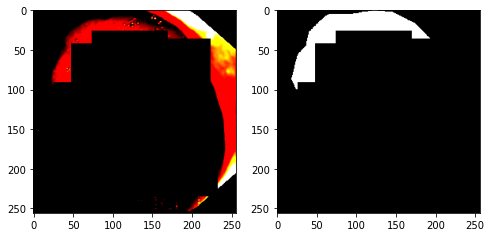

((3, 256, 256), (1, 256, 256))

In [ ]:
test = trans(data_train[0])
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(test['img'].cpu().numpy().transpose([1, 2, 0]))
plt.subplot(122)
plt.imshow(test['seg'][0].cpu(), cmap='gray')
plt.show()
test['img'].shape, test['seg'].shape

## Dataset and Dataloader

In [ ]:
batch_size = 32

ds_train = monai.data.CacheDataset(data_train, transform=trans)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size)

ds_val = monai.data.CacheDataset(data_val, transform=val_trans)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size)

Loading dataset: 100%|██████████| 200/200 [00:05<00:00, 35.09it/s]


## Network, loss and optimizer

In [ ]:
device = torch.device("cuda")

net = monai.networks.nets.SegResNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    dropout_prob=.5
).to(device)

net(test['img'][None, ...]).shape

(1, 1, 256, 256)

In [ ]:
class EMA():
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow, name
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(net.parameters(), 5e-4)
dice_metric = monai.metrics.DiceMetric(include_background=False, reduction="mean")
ema = EMA(net, 0.99)
ema.register()

## Train
Classic PyTorch for-loop

In [ ]:
!mkdir checkpoints

In [ ]:
max_epochs = 200
epoch_loss_values = []
epoch_valloss_values = []
metric_values = []
metric_values_ema = []
best_metric = 0
best_metric_epoch = -1

for epoch in range(max_epochs):
    print('Epoch: '+str(epoch+1)+'/'+str(max_epochs))
    # Train
    epoch_loss = 0
    net.train()
    ## Load data from training dataloader iteratively
    for step, batch_data in enumerate(dl_train):
        inputs, labels = (
            batch_data["img"],
            batch_data["seg"]
        )
        optimizer.zero_grad()
        ## Forward path
        outputs = net(inputs)
        ## Calculate loss
        loss = loss_function(outputs, labels)
        ## Backward 
        loss.backward()
        ## Update model
        optimizer.step()
        ema.update()
        epoch_loss += loss.item()
    epoch_loss /= (step+1)
    epoch_loss_values.append(epoch_loss)
    # Validation
    val_loss = 0
    net.eval()
    ## Disabled gradient calculation
    with torch.no_grad():
        ## Load data from validation dataloader iteratively
        for step, batch_data in enumerate(dl_val):
            val_inputs, val_labels = (
                batch_data["img"],
                batch_data["seg"]
            )
            ## Forward (Inference)
            val_outputs = net(val_inputs)
            ## Calculate loss
            loss = loss_function(val_outputs, val_labels)
            val_loss += loss.item()
            ## Calculate Dice score
            val_outputs = [post_trans(i) for i in monai.data.decollate_batch(val_outputs)]
            val_labels = monai.data.decollate_batch(val_labels)
            dice_metric(y_pred=val_outputs, y=val_labels)
        val_loss /= (step+1)
        epoch_valloss_values.append(val_loss)
        ## aggregate the final mean dice result
        metric = dice_metric.aggregate().item()
        ## reset the status for next validation round
        dice_metric.reset()
        metric_values.append(metric)
        ## EMA val
        ema.apply_shadow()
        for step, batch_data in enumerate(dl_val):
            val_inputs, val_labels = (
                batch_data["img"],
                batch_data["seg"]
            )
            ## Forward (Inference)
            val_outputs = net(val_inputs)
            ## Calculate loss
            loss = loss_function(val_outputs, val_labels)
            val_loss += loss.item()
            ## Calculate Dice score
            val_outputs = [post_trans(i) for i in monai.data.decollate_batch(val_outputs)]
            val_labels = monai.data.decollate_batch(val_labels)
            dice_metric(y_pred=val_outputs, y=val_labels)
        metric = dice_metric.aggregate().item()
        dice_metric.reset()
        metric_values_ema.append(metric)
        ema.restore()
        ## Save the model with the best metric
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), './checkpoints/best.pt')
        
    print(f'  Train_loss: {epoch_loss:.4f}')
    print(f'  Val_loss: {val_loss:.4f}', f', Val_dice: {metric_values[-1]:.4f}, Val_dice_ema: {metric_values_ema[-1]:.4f}')
torch.save(net.state_dict(), './checkpoints/last.pt')

Epoch: 1/200
  Train_loss: 0.8339
  Val_loss: 6.0786 , Val_dice: 0.3749, Val_dice_ema: 0.2145
Epoch: 2/200
  Train_loss: 0.8263
  Val_loss: 5.9315 , Val_dice: 0.3987, Val_dice_ema: 0.3292
Epoch: 3/200
  Train_loss: 0.8164
  Val_loss: 5.8706 , Val_dice: 0.4155, Val_dice_ema: 0.3739
Epoch: 4/200
  Train_loss: 0.7994
  Val_loss: 5.8124 , Val_dice: 0.4179, Val_dice_ema: 0.4014
Epoch: 5/200
  Train_loss: 0.7995
  Val_loss: 5.7560 , Val_dice: 0.4436, Val_dice_ema: 0.4202
Epoch: 6/200
  Train_loss: 0.7882
  Val_loss: 5.6939 , Val_dice: 0.4625, Val_dice_ema: 0.4314
Epoch: 7/200
  Train_loss: 0.7853
  Val_loss: 5.6256 , Val_dice: 0.4713, Val_dice_ema: 0.4414
Epoch: 8/200
  Train_loss: 0.7684
  Val_loss: 5.5522 , Val_dice: 0.4761, Val_dice_ema: 0.4531
Epoch: 9/200
  Train_loss: 0.7611
  Val_loss: 5.4776 , Val_dice: 0.4793, Val_dice_ema: 0.4640
Epoch: 10/200
  Train_loss: 0.7559
  Val_loss: 5.4084 , Val_dice: 0.4801, Val_dice_ema: 0.4714
Epoch: 11/200
  Train_loss: 0.7532
  Val_loss: 5.3362 , Val

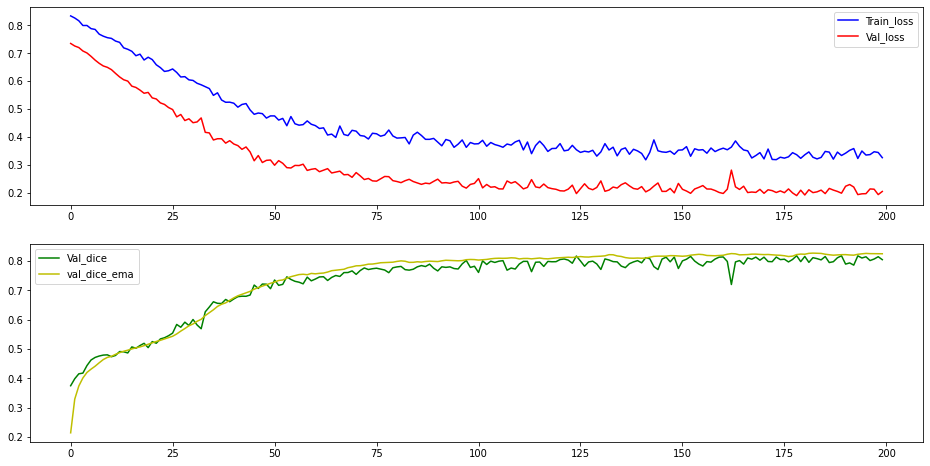

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.plot(epoch_loss_values, 'b')
plt.plot(epoch_valloss_values, 'r')
plt.legend(['Train_loss', 'Val_loss'])
plt.subplot(212)
plt.plot(metric_values, 'g')
plt.plot(metric_values_ema, 'y')
plt.legend(['Val_dice', 'val_dice_ema'])
plt.show()

In [ ]:
best_metric, best_metric_epoch

(0.826556384563446, 183)

## Visualization

In [ ]:
# Restore the best checkpoint
best_ckpt_dict = torch.load('./checkpoints/best.pt')
net.load_state_dict(best_ckpt_dict)

In [ ]:
# Get one val data and inference
load_resize = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True),
                                        monai.transforms.EnsureChannelFirst(),
                                        monai.transforms.Resize(spatial_size=spatial_size, mode='area')])

fpath = data_val[0]
img = load_resize(fpath['img'])
data = val_trans(fpath)
inputs = data['img'][None, ...]
label = data['seg'][None, ...]
net.eval()
output = net(inputs)
output = post_trans(output)
inputs.shape, label.shape, output.shape, img.shape

In [ ]:
# Plot the results
plt.figure(figsize=(20, 5))
plt.subplot(141)
plt.imshow(img.numpy().transpose([1, 2, 0]).astype('uint8'))
plt.title('Image')
plt.subplot(142)
plt.imshow(inputs[0].cpu().numpy().transpose([1, 2, 0]))
plt.title('Pre-processed Image')
plt.subplot(143)
plt.imshow(label[0, 0].cpu().numpy(), cmap='gray')
plt.title('Ground Truth')
plt.subplot(144)
plt.imshow(output[0, 0].cpu().numpy(), cmap='gray')
plt.title('Prediction')
plt.show()

## Export
Export the model to ONNX format

In [ ]:
dummy_input = torch.randn(batch_size, 3, 256, 256).to(device)

with torch.no_grad():
    print(net(dummy_input).shape)

In [ ]:
torch.onnx.export(net, dummy_input, 'model.onnx')

## Exploration
Try to use different architecture, transformation and hyperparameter to improve the model.